# Introduction to Pydantic.ai

Now that we have seen in theory how pydantic ai works, let's use it in practice to accomplish something useful!

First, make sure you have setup your credentials like this:

```bash
cp env.example .env
```

Then open .env and insert your API key for Gemini, like this:

```yaml
GEMINI_API_KEY=[your key]
...
```
while leaving the rest untouched.

Then we can load the credentials like this:

In [ ]:
from dotenv import load_dotenv
load_dotenv()

# Only needed on the Udacity workspace. Comment this out if running on another system.
import os
os.environ['HF_HOME'] = '/voc/data/huggingface'
os.environ['OLLAMA_MODELS'] = '/voc/data/ollama/cache'
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['PATH'] = f"/voc/data/ollama/bin:/voc/data/ffmpeg/bin:{os.environ.get('PATH', '')}"
os.environ['LD_LIBRARY_PATH'] = f"/voc/data/ollama/lib:/voc/data/ffmpeg/lib:{os.environ.get('LD_LIBRARY_PATH', '')}"

True

Since Pydantic AI uses asyncio (asyncronous code), we need to do this if we are running in jupyter:

**NOTE**: this is not necessary if you are writing scripts. Also, if you know how to use asyncio in python, you can use the async version of pydantic AI (i.e., change all the calls to `run_sync` to `await run(...)` in the following code and you can then insert it in your async codebase)

In [4]:
import nest_asyncio
nest_asyncio.apply()

Not doing this would give us a `RuntimeError: This event loop is already running` error.


Let's first create some utilities that we will use later:

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
    

def display_image_with_caption(image: Image.Image, caption: str):
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(caption, wrap=True, fontsize=8, pad=20)
    plt.tight_layout()
    plt.show()

# This gets a random image 400x300. It will be a different image
# every time you run this cell!
image = Image.open("matterhorn.png")

## Image analysis with Pydantic AI and Gemini

Let's use Pydantic AI and Gemini to do some image analysis. Let's start with a vanilla example:

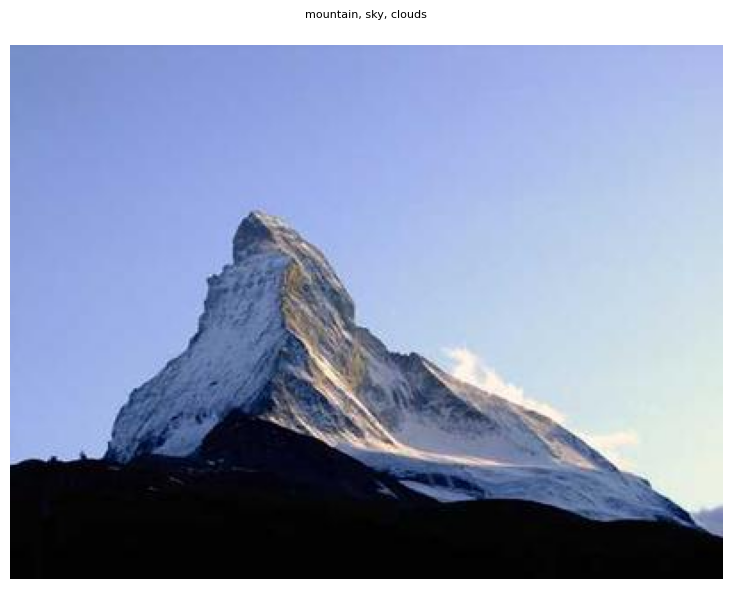

In [16]:

from pydantic_ai import Agent
from pydantic_ai.messages import BinaryContent
from io import BytesIO

prompt = "List as many objects as you can that are present in this image and return them as a comma-separated list."

# Create agent with Gemini model
agent = Agent('google-gla:gemini-2.5-flash-lite')


def analyze_image_with_pydantic_ai(img: Image.Image, prompt: str) -> str:
    
    # Limit size to at most 600x600 to limit the usage of tokens
    img.thumbnail((600, 600))
    
    # Format image for pydantic-ai
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    img_bytes = image_bytes.getvalue()
    binary_content = BinaryContent(
        data=img_bytes, 
        media_type='image/jpeg'
    )
    
    # Run the agent with image and prompt
    result = agent.run_sync([
        prompt,
        binary_content
    ])
    
    return result.output


caption = analyze_image_with_pydantic_ai(
    image,
    prompt
)

display_image_with_caption(image, caption)


Now let's first add structured output, so we force the model to respond in a very specific way that we could then leverage downstream if our code was part of a larger system:

In [17]:
from pydantic import BaseModel
from typing import Literal

# Pydantic model for structured output
# This is essentially the schema of the output that we will get from
# the AI model
class ImageAnalysis(BaseModel):
    """
    Analyze the provided image and look for objects, classify it, provide a description 
    and estimate the location of the picture.
    """
    main_objects: list[str]
    image_type: Literal["city", "nature", "other"]  # classification
    scene_description: str
    estimated_location: str


# Create agent with structured output and dependencies
agent = Agent(
    'google-gla:gemini-2.5-flash',
    output_type=ImageAnalysis,
    system_prompt=(
        "You are an expert image analyst. Analyze images and provide structured output. "
    )
)


def analyze_image_with_structured_output(img: Image.Image) -> ImageAnalysis:
    
    # Limit size to reduce token usage
    img.thumbnail((600, 600))
    
    # Format image
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    
    # Run analysis
    result = agent.run_sync(
        [BinaryContent(data=image_bytes.getvalue(), media_type='image/jpeg')],
    )
    
    return result.output

# Analyze image with structured output
analysis = analyze_image_with_structured_output(image)

In [ ]:
# Analysis is now an instance of ImageAnalysis
isinstance(analysis, ImageAnalysis)

True

In [24]:
# We can access its elements using the dot notation
print(analysis.image_type)

# or convert it to a dictionary
analysis_as_dict = analysis.model_dump()
print(analysis_as_dict)

nature
{'main_objects': ['snow-capped mountain', 'sky'], 'image_type': 'nature', 'scene_description': 'A majestic snow-capped mountain dominates the frame under a clear blue sky, with its lower slopes shrouded in shadow.', 'estimated_location': 'Matterhorn, Swiss/Italian Alps'}


In [25]:
# We can pretty-print it using json
print("=== Image Analysis Results ===")
print(analysis.model_dump_json(indent=4))

=== Image Analysis Results ===
{
    "main_objects": [
        "snow-capped mountain",
        "sky"
    ],
    "image_type": "nature",
    "scene_description": "A majestic snow-capped mountain dominates the frame under a clear blue sky, with its lower slopes shrouded in shadow.",
    "estimated_location": "Matterhorn, Swiss/Italian Alps"
}


In [ ]:
# Since we know the schema, we can then take decisions or do whatever else
# we need later on
if analysis.image_type == "nature":
    # Do whatever with this information
    print("let nature be your teacher")
elif analysis.image_type == "city":
    print("when the lights go down in the city...")
else:
    print("What is this?")

Finally, sometimes it is useful to be able to tweak options without having to change the code of your agent, this is where Dependencies come in:

In [28]:
from pydantic import BaseModel
from typing import Literal
from dataclasses import dataclass
from pydantic_ai import RunContext


# Pydantic model for structured output
class ImageAnalysis(BaseModel):
    """
    Analyze the provided image and look for objects, classify it, provide a description and estimate the location of the picture.
    """
    main_objects: list[str]
    image_type: Literal["city", "nature", "other"]  # classification
    scene_description: str
    estimated_location: str


# Create agent with structured output and dependencies
agent = Agent(
    'google-gla:gemini-2.5-flash',
    output_type=ImageAnalysis,
    retries=5
    # NOTE: this is commented because we will generate the system prompt
    # dynamically
    # system_prompt=(
    #     "You are an expert image analyst. Analyze images and provide structured output. "
    # )
)

@dataclass
class OptionsDeps:
    description_verbosity: Literal["brief", "verbose"] = "brief"

# For example, change the system prompt using the options
@agent.system_prompt
def dynamic_prompt(ctx: RunContext[OptionsDeps]) -> str:
    
    system_prompt = """
    You are an expert image analyst. Analyze images and provide structured output.
    """
    if ctx.deps.description_verbosity == "brief":
        system_prompt += " Keep the description very brief, use a max of 5 words."
    elif ctx.deps.description_verbosity == "verbose":
        system_prompt += " Provide an extremely detailed description."
    
    return system_prompt


def analyze_image_with_structured_output(img: Image.Image, deps: OptionsDeps) -> ImageAnalysis:
    
    # Limit size to reduce token usage
    img.thumbnail((600, 600))
    
    # Format image
    image_bytes = BytesIO()
    img.save(image_bytes, format='JPEG')
    
    # Run analysis with the provided options
    result = agent.run_sync(
        [BinaryContent(data=image_bytes.getvalue(), media_type='image/jpeg')],
        deps=deps
    )
    
    return result.output

# Analyze image with structured output
my_options = OptionsDeps(description_verbosity="brief")
analysis = analyze_image_with_structured_output(image, my_options)

# The output is an instance of our output model. We can pretty-print it
# using json
print("=== Image Analysis Results with brief ===")
print(analysis.model_dump_json(indent=4))

my_options = OptionsDeps(description_verbosity="verbose")
analysis = analyze_image_with_structured_output(image, my_options)

print("=== Image Analysis Results with verbose ===")
print(analysis.model_dump_json(indent=4))

=== Image Analysis Results with brief ===
{
    "main_objects": [
        "mountain",
        "snow",
        "sky"
    ],
    "image_type": "nature",
    "scene_description": "Snowy mountain, clear blue sky",
    "estimated_location": "The Alps (Switzerland/Italy, likely Matterhorn area.)"
}
=== Image Analysis Results with verbose ===
{
    "main_objects": [
        "snow-capped mountain"
    ],
    "image_type": "nature",
    "scene_description": "A majestic, triangular-shaped mountain, largely covered in snow and ice, stands prominently against a clear, deep blue sky. The lower part of the mountain is shrouded in dark shadow, creating a strong contrast with the brightly illuminated snow on its upper slopes, which appear to be hit by direct sunlight. The mountain's peak is sharply defined and rugged, characteristic of an alpine environment. Small patches of clouds or mist can be seen near its lower snowline on the right side. The overall impression is one of grandeur and stark beauty

## Not only images

In the same way you can also analyze audio or video. For example:

In [15]:

from IPython.display import Audio, display


class AudioAnalysis(BaseModel):
    """
    Analyze the provided audio.
    """
    transcription: str
    audio_type: Literal["speech", "music", "environment"]


# Create agent with structured output and dependencies
agent = Agent(
    'google-gla:gemini-2.5-flash',
    output_type=AudioAnalysis,
    system_prompt=(
        "You are an expert sound analyst. Analyze sounds and provide structured output. "
    )
)


def analyze_sound_with_structured_output(audio_bytes: bytes, prompt: str) -> AudioAnalysis:
    
    # Run analysis
    result = agent.run_sync(
        [
            prompt, 
            BinaryContent(data=audio_bytes, media_type='audio/wav')
        ],
    )
    
    return result.output

# Example usage with WAV file bytes
# Assuming you have audio_bytes containing WAV file data
audio_bytes = open("LJ025-0076.wav", "rb").read()
caption = analyze_sound_with_structured_output(
    audio_bytes,
    "Analyze this audio"
)

display(Audio("LJ025-0076.wav"))

print(caption.model_dump_json(indent=4))

{
    "transcription": "Many animals of even complex structure which live parasitically within others are wholly devoid of an alimentary cavity.",
    "audio_type": "speech"
}
